In [275]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%load_ext autoreload
%autoreload 2

ecmwf_path = "data/preprocessed/BR/ecmwf_era_wheat_BR.csv"
predictor_path = "data/preprocessed/BR/ndvi_soil_soil_moisture_meteo_fpar_wheat_BR.csv"
yield_path = "data/CY-Bench/BR/wheat/yield_wheat_BR.csv"
shapefile_path = "data/shapefiles/BR/bra_admbnda_adm2_ibge_2020.shp"
static_features = ["harvest_year", "awc", "bulk_density", "drainage_class_2", "drainage_class_3", "drainage_class_4", "drainage_class_5", "drainage_class_6"]
southern_adm_ids = [i.strip("\n").strip().strip("'") for i in open("data/southern_adm_ids_BR_wheat.txt", "r").read().split(',')]
br = gpd.read_file(shapefile_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


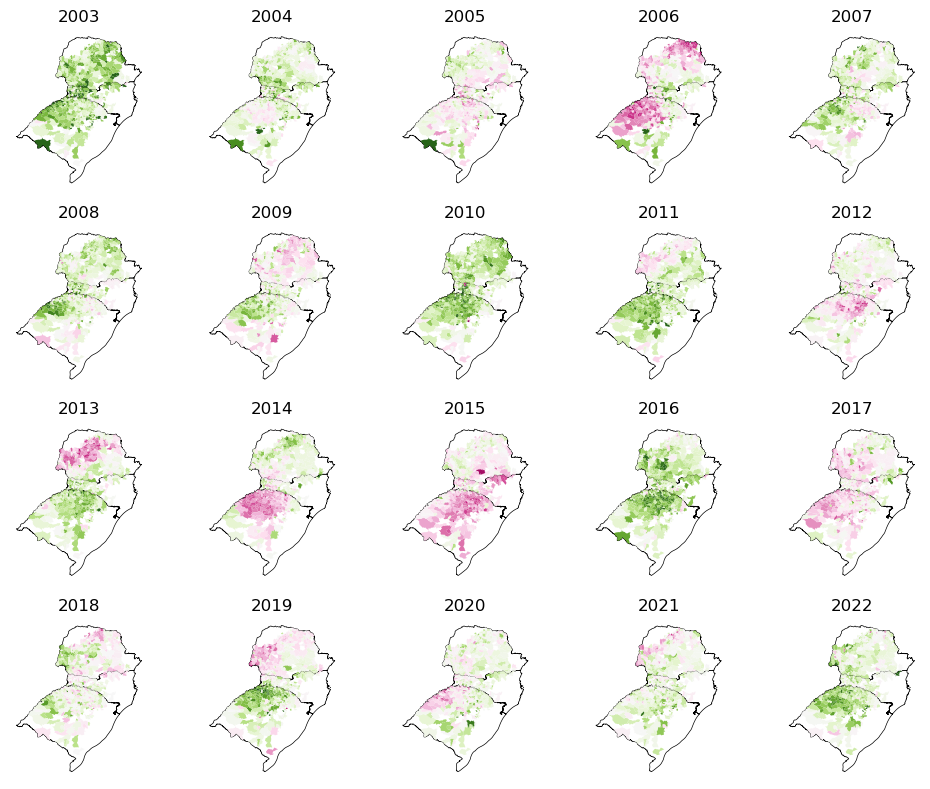

In [160]:
yield_df = pd.read_csv(yield_path)
yield_df = yield_df.loc[yield_df["adm_id"].isin(southern_adm_ids) & (yield_df["harvest_year"].between(1998, 2022)), ["adm_id", "harvest_year", "yield"]].set_index("adm_id")
yield_df = yield_df.loc[yield_df.groupby(yield_df.index).size() >= 20].pivot(columns="harvest_year", values="yield").interpolate(axis=1, limit_direction='both')
yield_df = yield_df.apply(lambda x: (x - x.rolling(5, closed="left").mean()) / x.rolling(5, closed="left").mean(), axis=1).dropna(axis=1)
yield_df = gpd.GeoDataFrame(yield_df.reset_index().merge(br[["ADM2_PCODE", "geometry"]], left_on="adm_id", right_on="ADM2_PCODE"), geometry="geometry").drop(columns=["ADM2_PCODE"])

fig, axs = plt.subplots(4,5, figsize=(10, 8))
axs = axs.ravel()
soutern_states = br.loc[br["ADM1_PT"].isin(["Paraná", "Santa Catarina", "Rio Grande do Sul"])].dissolve("ADM1_PT")
for i, year in enumerate(list(range(2003, 2023))):
    soutern_states.plot(edgecolor="black", ax=axs[i], facecolor="none", linewidth=.5)
    yield_df.plot(column=year, ax=axs[i], legend=False, cmap="PiYG", vmin=-1, vmax=1)
    axs[i].set_title(year)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [208]:
def get_yield_and_predictors(yield_path, predictor_path, ecmwf_path, southern_adm_ids):
    """
    Load yield and predictors data, merge them, filter by year and admin_ids, and return the resulting dataframe.
    
    Params:
        yield_path: str, path to the yield data
        predictor_path: str, path to the cy-bench data
        ecmwf_path: str, path to the ecmwf data
        southern_adm_ids: list, list of admin_ids to filter by
    
    Returns:
        x_y: pd.DataFrame, merged dataframe
    """
    y = pd.read_csv(yield_path)
    y = y.loc[(y["harvest_year"].between(1998, 2022)) & (y["adm_id"].isin(southern_adm_ids)), ["adm_id", "harvest_year", "yield"]].set_index("adm_id")
    y = y.loc[y.groupby(y.index).size() >= 20].pivot(columns="harvest_year", values="yield").interpolate(axis=1, limit_direction='both')
    y = y.apply(lambda x: 100 * (x - x.rolling(5, closed="left").mean()) / x.rolling(5, closed="left").mean(), axis=1).dropna(axis=1).reset_index()
    y = y.melt(id_vars="adm_id", var_name="harvest_year", value_name="yield")
    ecmwf = pd.read_csv(ecmwf_path)
    cy_bench = pd.read_csv(predictor_path)
    x = ecmwf.merge(cy_bench, on=["adm_id", "harvest_year"], how="left").dropna().reset_index(drop=True)
    x_y = x.merge(y, on=["adm_id", "harvest_year"], how="inner")
    # to bring harvest year and yield columns to the front
    x_y = x_y.set_index(["adm_id", "harvest_year", "yield"]).reset_index(level=[1, 2])
    
    return x_y

def get_temporal_feature_subset(df, feature_prefix_list):
    """
    Filter temporal features by prefix and return the resulting list of features names.
    
    Params:
        df: pd.DataFrame, dataframe containing the features as column names
        feature_prefix_list: list, list of prefixes to filter by
    
    Returns:
        filtered_temporal_features: list, list of filtered temporal feature names
    """
    all_columns = df.columns
    filtered_temporal_features = [f for f in all_columns if any([f.startswith(prefix) for prefix in feature_prefix_list])]
    return filtered_temporal_features

def temporal_aggregation(df, feature_prefix_list, window_size):
    """
    Aggregate steps of temporal features and return the resulting dataframe.
    
    Params:
        df: pd.DataFrame, dataframe containing the features and time steps as column names
        feature_prefix_list: list, list of prefixes of temporal features that should be aggregated
        steps: int, number of steps to aggregate by
    """
    li = []
    df = df.set_index(["yield"] + static_features, append=True)
    for feature in feature_prefix_list:
        li.append(df[get_temporal_feature_subset(df, [feature])].rolling(window=window_size, step=window_size, closed="right", axis=1).mean().dropna(axis=1))
    
    df = pd.concat(li, axis=1).reset_index().set_index("adm_id")
    return df

In [209]:
xy = get_yield_and_predictors(yield_path, predictor_path, ecmwf_path, southern_adm_ids)

______

### Following step will be part of dataloader:

keep only end-of-season

In [210]:
xy = xy.loc[pd.to_datetime(xy["init_date"]).dt.month == 12].drop("init_date", axis=1)

In [285]:
xy_temporal_aggregated = temporal_aggregation(xy, ["tavg", "tmin", "tmax", "prec"], 3)

In [272]:
xy_temporal_aggregated.head()

,yield,harvest_year,awc,bulk_density,drainage_class_2,drainage_class_3,drainage_class_4,drainage_class_5,drainage_class_6,tavg_19,tavg_22,tavg_25,tavg_28,tavg_31,tavg_34,tavg_37,tavg_40,tmin_19,tmin_22,tmin_25,tmin_28,tmin_31,tmin_34,tmin_37,tmin_40,tmax_19,tmax_22,tmax_25,tmax_28,tmax_31,tmax_34,tmax_37,tmax_40,prec_19,prec_22,prec_25,prec_28,prec_31,prec_34,prec_37,prec_40,ndvi_19,ndvi_22,ndvi_25,ndvi_28,ndvi_31,ndvi_34,ndvi_37,ndvi_40,rad_19,rad_22,rad_25,rad_28,rad_31,rad_34,rad_37,rad_40,et0_19,et0_22,et0_25,et0_28,et0_31,et0_34,et0_37,et0_40,cwb_19,cwb_22,cwb_25,cwb_28,cwb_31,cwb_34,cwb_37,cwb_40,ssm_19,ssm_22,ssm_25,ssm_28,ssm_31,ssm_34,ssm_37,ssm_40,rsm_19,rsm_22,rsm_25,rsm_28,rsm_31,rsm_34,rsm_37,rsm_40
adm_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BR4100103,46.590185,2003,12.063801,1.3346,0.0,0.0,0.0,1.0,0.0,18.257282,18.277678,17.485087,17.008531,17.834496,20.912597,20.925639,22.056362,13.801199,13.403383,13.247075,12.341918,13.156386,15.680141,16.526071,17.122296,24.115061,24.606146,23.375460,23.535350,24.539113,27.693128,26.923244,27.579870,2.757083,0.018333,1.732083,1.805000,2.248750,1.573750,3.574583,5.415000,180.368688,182.326232,175.999587,167.968778,152.756838,150.837391,161.803464,164.905658,1.344951e+07,1.436506e+07,1.285670e+07,1.598678e+07,1.707211e+07,2.068119e+07,2.015770e+07,2.221282e+07,2.564691,2.540066,2.624548,3.185146,3.675276,4.551323,4.503104,4.901513,0.192392,-2.521732,-0.892465,-1.380146,-1.406943,-2.977573,-0.928520,0.513487,6.238179,6.157195,6.364416,5.985547,5.704781,5.707910,6.003327,5.991327,306.679278,309.636564,313.281214,300.385829,290.702578,290.861835,297.577845,296.687452
BR4100103,20.700060,2004,12.063801,1.3346,0.0,0.0,0.0,1.0,0.0,15.487047,17.596155,16.487573,16.752435,22.512219,21.822952,20.978243,21.856321,11.983764,13.162671,13.427516,10.980922,16.466881,16.687806,16.507034,17.404256,19.929286,22.711407,20.927208,22.763434,29.690077,28.660353,26.555320,26.329808,5.787083,1.547917,3.214583,0.016250,0.227917,1.312083,8.018333,6.140416,183.972009,185.270927,185.419109,173.770777,153.963330,143.826646,156.029719,173.060941,1.168549e+07,1.247769e+07,1.109909e+07,1.675139e+07,1.884857e+07,1.972519e+07,1.937518e+07,2.022973e+07,1.968433,2.214689,2.198035,3.208405,4.506767,4.702892,4.204121,4.300075,3.818650,-0.666773,1.016548,-3.192155,-4.278851,-3.390808,3.814212,1.840341,6.881684,6.488459,6.671779,6.185092,5.570112,5.523642,6.507210,6.675779,330.553768,321.754191,324.926044,312.670470,292.117498,286.085711,312.242874,320.565778
BR4100103,22.306348,2005,12.063801,1.3346,0.0,0.0,0.0,1.0,0.0,19.757011,18.845162,16.100162,18.722505,20.056445,19.577971,22.059076,22.439166,15.576609,14.807606,12.122429,12.851899,15.310507,15.573470,18.257056,17.290443,24.582260,23.588671,21.007848,25.097415,26.373471,24.524834,27.296843,27.041758,4.203750,1.670000,1.563333,0.235833,2.433333,6.636666,6.440416,2.910833,171.139690,184.955403,183.901901,171.054028,157.496280,164.580591,173.842928,175.046250,1.330349e+07,1.172793e+07,1.295581e+07,1.657980e+07,1.716159e+07,1.623066e+07,1.787722e+07,2.170698e+07,2.541464,2.310563,2.510804,3.286236,3.946924,3.522180,3.898327,4.750886,1.662286,-0.640564,-0.947470,-3.050403,-1.513591,3.114487,2.542089,-1.840053,6.318202,6.254744,6.202591,5.957986,5.702122,6.218566,6.558939,6.274437,309.464825,308.625443,305.394597,301.893372,289.699256,305.656848,313.375959,310.107080
BR4100103,-75.398048,2006,12.063801,1.3346,0.0,0.0,0.0,1.0,0.0,18.288001,17.831133,19.263183,20.465658,18.310218,20.235679,22.773229,23.137581,13.986795,13.646472,13.688848,15.582227,12.537353,16.297595,18.006035,18.237829,24.160840,23.382423,25.599228,26.703244,24.904200,25.823517,27.723525,28.605034,0.730833,0.869583,1.401667,0.484583,2.136250,4.838750,1.391250,2.336250,161.761760,155.501353,156.419146,159.012323,149.620942,161.682340,176.024309,170.563946,1.340001e+07,1.262084e+07,1.484355e+07,1.482018e+07,1.927933e+07,1.593213e+07,2.010154e+07,2.1

_____

In [286]:
groups = xy_temporal_aggregated["harvest_year"] 
X = xy_temporal_aggregated.drop(["yield", "drainage_class_2", "drainage_class_3", "drainage_class_4", "drainage_class_5", "drainage_class_6"], axis=1)
y = xy_temporal_aggregated["yield"]

print(X.columns)
#model = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_depth=5, max_features=10, random_state=0)
model = AdaBoostRegressor(learning_rate=1,  n_estimators=100, random_state=0)
#pipe = Pipeline([
#    ("scaler", StandardScaler()), ("select", SelectKBest(k=10)), ('estimator', model)
#])

# Parameters for grid search
param_grid = {
    'n_jobs': [-1],
    'n_estimators': [5],
}

# Outer CV for splitting dataset based on groups
outer_cv = LeaveOneGroupOut()

# List to store scores
outer_scores = []

for train_idx, test_idx in outer_cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    #groups_train = groups[train_idx]
    print(X_test["harvest_year"].unique())
    # Inner CV based on groups
    #inner_cv = LeaveOneGroupOut()

    # Grid search with inner group cross-validation
    #grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv.split(X_train, y_train, groups_train), scoring='neg_mean_squared_error')
    #grid_search.fit(X_train, y_train)

    # Best model from grid search
    #best_model = grid_search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = y_test.to_frame().assign(y_pred=y_pred)
    res = res.assign(error=(res["yield"] - res["y_pred"])).reset_index()
    print(np.round(root_mean_squared_error(y_test, y_pred), 2))
    print(r2_score(y_test, y_pred))
    #br.merge(res, left_on="ADM2_PCODE", right_on="adm_id", how="inner").plot(column="error", legend=True, cmap="PiYG", figsize=(5, 5))
    
    # Evaluate the best model on the outer test set
    #y_pred = best_model.predict(X_test)
    #score = np.round(100 * root_mean_squared_error(y_test, y_pred) / np.mean(y_test), 4)
    #outer_scores.append(score)

    #print(f"Fold RMSE: {score}")

# Average score across all outer folds
#average_rmse = np.mean(outer_scores)
#print(f"Average RMSE: {average_rmse}")
    

Index(['harvest_year', 'awc', 'bulk_density', 'tavg_19', 'tavg_22', 'tavg_25',
       'tavg_28', 'tavg_31', 'tavg_34', 'tavg_37', 'tavg_40', 'tmin_19',
       'tmin_22', 'tmin_25', 'tmin_28', 'tmin_31', 'tmin_34', 'tmin_37',
       'tmin_40', 'tmax_19', 'tmax_22', 'tmax_25', 'tmax_28', 'tmax_31',
       'tmax_34', 'tmax_37', 'tmax_40', 'prec_19', 'prec_22', 'prec_25',
       'prec_28', 'prec_31', 'prec_34', 'prec_37', 'prec_40'],
      dtype='object')
[2003]
33.96
-0.3997849578323269
[2004]


KeyboardInterrupt: 

In [205]:
mean_absolute_error(res["yield"], res["y_pred"])

0.3221521968314974

In [107]:
yield_df = pd.read_csv(yield_path)
yield_df.loc[yield_df["adm_id"].isin(southern_adm_ids) & (yield_df["harvest_year"].between(2003,2022)), "yield"].describe()

count    15745.000000
mean         2.315170
std          0.740944
min          0.000000
25%          1.800000
50%          2.360000
75%          2.800000
max          7.200000
Name: yield, dtype: float64

In [85]:
res.squared_error.mean()

0.27782335460792085

In [83]:
res.squared_error.mean()

0.2790859465936118

In [ ]:
{2003: 21.371985571725027,
 2004: 24.226039341517858,
 2005: 28.865666253226145,
 2007: 21.775109427315847,
 2008: 22.52009391784668,
 2009: 22.59456879752023,
 2010: 20.27269118172782,
 2011: 28.58042417253767,
 2012: 24.6958065032959,
 2013: 26.50239862714495,
 2014: 29.388872146606445,
 2016: 22.433117730276926,
 2018: 29.083726610456193,
 2019: 24.842851366315568,
 2020: 23.958420617239817,
 2021: 20.430754252842494,
 2022: 17.276971340179443}

In [2]:


def fullfill_fpar_timesteps(df):
    min_time_step = min([int(c.split("_")[1]) for c in [l for l in df.columns if "tavg" in l]])
    max_time_step = max([int(c.split("_")[1]) for c in [l for l in df.columns if "tavg" in l]])
    fpar_columns = [c for c in df.columns if "fpar" in c]
    fpar_columns_all_timesteps = ["fpar_{}".format(n) for n in list(range(min_time_step, max_time_step + 1))]
    new_fpar_columns = list(set(fpar_columns_all_timesteps).difference(set(fpar_columns)))
    df[new_fpar_columns] = np.nan
    df[fpar_columns_all_timesteps] = df[fpar_columns_all_timesteps].interpolate(method='linear', axis=1)
    df = df.reindex(sorted(df.columns), axis=1)
    return df



#def RMSELoss(yhat,y):
#    return 100 * torch.sqrt(torch.mean((yhat-y)**2)) / torch.mean(y)

#def count_parameters(model):
#    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_feature_arrays_for_lstm(df, static_features, feature_prefixes):
    feature_list = []
    for prefix in feature_prefixes:
        feature_list.append(df[[c for c in df.columns if prefix in c]])

    seq_train_stacked = np.stack(feature_list, axis=-1)
    static_train = df[static_features].values
    
    return seq_train_stacked, static_train

### Analyse mutual info regression

In [6]:
train_df = train_df[["yield"] + get_feature_subset(train_df, ["tavg", "prec", 'tmax', 'tmin', "fpar", "ndvi", "ssm", "rsm", "cwb", "et0", "rad"])]

In [11]:
unique_years = train_df['harvest_year'].unique()
unique_years.sort()
seq_feature_prefixes = ["tavg", "prec", 'tmax', 'tmin', "fpar", "ndvi", "ssm", "rsm", "cwb", "et0", "rad"]
li = []

for year in unique_years:
    print(f'MI on year {year}')
    train_fold_df =  train_df[ train_df['harvest_year'] != year].copy()
    train_fold_features = train_fold_df.drop(columns=['yield'])
    train_fold_target = train_fold_df['yield']
    
    means = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).mean()
    stds = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).std()
    means.loc[:, static_features] = 0
    stds.loc[:, static_features] = 1
    train_fold_features = (train_fold_features - means) / stds
    
    mi = mutual_info_regression(train_fold_features, train_fold_target)
    mi_df = pd.DataFrame({'feature': train_fold_features.columns, 'mi': mi, 'year': year}).pivot(index='year', columns='feature', values='mi')
    li.append(mi_df)
    
mi_df_all_years = pd.concat(li, axis=0)

MI on year 2003
MI on year 2004
MI on year 2005
MI on year 2007
MI on year 2008
MI on year 2009
MI on year 2010
MI on year 2011
MI on year 2012
MI on year 2013
MI on year 2014
MI on year 2016
MI on year 2018
MI on year 2019
MI on year 2020
MI on year 2021
MI on year 2022


In [24]:
mi_mean = pd.DataFrame(mi_df_all_years.mean()).rename(columns={0: 'mean_mi'}).sort_values(by='mean_mi', ascending=False).reset_index()

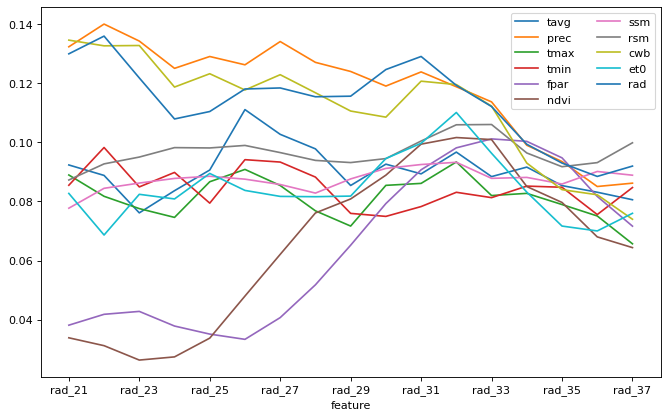

In [59]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

for prefix in seq_feature_prefixes:
    mi_mean.loc[mi_mean['feature'].str.contains(prefix)].sort_values(by="feature").set_index("feature")["mean_mi"].rolling(3).mean().plot(label=prefix)
plt.legend(loc='upper right', ncol=2)

In [7]:
mutual_info_regression(train_df[["tavg_20", "prec_20"]], train_df["yield"])

array([0.09351906, 0.15419409])

### Model

In [66]:
unique_years = train_df['harvest_year'].unique()
unique_years.sort()
results = dict.fromkeys(unique_years)

seq_feature_prefixes = ["prec", "fpar", "ndvi", "cwb", "rad"]

batch_size = 32
num_epochs = 30
patience = 5

seq_input_size = len(seq_feature_prefixes)
static_input_size = len(static_features)
static_layer_1 = 100
static_layer_2 = 50
hidden_size = 100
lstm_layers = 2
dropout = 0.3
dense_size = 100
dense_size_1 = 100 
dense_size_2 = 100
output_size = 1


for year in unique_years:
    if (year not in [2022]): continue
    print(f'Validating on year {year}')
    train_fold_df =  train_df[ train_df['harvest_year'] != year].copy()
    val_fold_df =  train_df[ train_df['harvest_year'] == year].copy()
    train_fold_features = train_fold_df.drop(columns=['yield'])
    train_fold_target = train_fold_df['yield']
    val_fold_features = val_fold_df.drop(columns=['yield'])
    val_fold_target = val_fold_df['yield']
    
    means = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).mean()
    stds = train_fold_features.groupby(train_fold_features.index.get_level_values(0)).std()
    means.loc[:, static_features] = 0
    stds.loc[:, static_features] = 1
    means_aligned =  means.reindex(val_fold_features.index)
    std_aligned = stds.reindex(val_fold_features.index)
    train_fold_features = (train_fold_features - means) / stds
    val_fold_features = (val_fold_features - means_aligned) / std_aligned

    seq_train_stacked, static_train = get_feature_arrays_for_lstm(train_fold_features, static_features, seq_feature_prefixes)
    seq_val_stacked, static_val = get_feature_arrays_for_lstm(val_fold_features, static_features, seq_feature_prefixes)
   
    #train_fold_dataset = CombinedDataset(seq_train_stacked, static_train, train_fold_target)
    #val_fold_dataset = CombinedDataset(seq_val_stacked, static_val, val_fold_target)
    train_fold_dataset = SequentialYieldPredictors(seq_train_stacked, train_fold_target)
    val_fold_dataset = SequentialYieldPredictors(seq_val_stacked, val_fold_target)
    
    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)
    
    # Reset the model and optimizer
    #model = CombinedModel(seq_input_size, static_input_size, static_layer_1, static_layer_2, hidden_size, lstm_layers, 
    #             dropout, dense_size_1, dense_size_2, output_size)
    model = LSTMRegression(seq_input_size, hidden_size, lstm_layers, dense_size, 1)
    optimizer = optim.Adadelta(model.parameters())
    criterion = RMSELoss
    print(count_parameters(model))
    
    # Early stopping parameters
    best_val_loss = float('inf')  # Initialize the best validation loss
    epochs_no_improve = 0  # Counter for epochs without improvement
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for features_dynamic, target in train_fold_loader:
            optimizer.zero_grad()
            output = model(features_dynamic)
            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features_dynamic, target in val_fold_loader:
                output = model(features_dynamic)
                loss = criterion(output, target.unsqueeze(1))
                val_loss += loss.item()
        
        val_loss /= len(val_fold_loader)  # Compute the average validation loss
        print(f'Epoch {epoch + 1}, Validation Loss for year {year}: {np.round(val_loss, 2)}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0  # Reset the counter if validation loss improves
        else:
            epochs_no_improve += 1  # Increment the counter if validation loss does not improve
        
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break  # Stop training if no improvement for specified number of epochs
    
    results[year] = np.round(best_val_loss, 2)


Validating on year 2022
143901
Epoch 1, Validation Loss for year 2022: 28.92
Epoch 2, Validation Loss for year 2022: 30.69
Epoch 3, Validation Loss for year 2022: 32.78
Epoch 4, Validation Loss for year 2022: 28.9
Epoch 5, Validation Loss for year 2022: 29.12
Epoch 6, Validation Loss for year 2022: 32.0


KeyboardInterrupt: 

In [ ]:
results

{2003: 21.895093477689304,
 2004: 25.186617919376918,
 2005: 31.715064415564903,
 2007: 21.421781980074368,
 2008: 22.618428156926083,
 2009: 23.59405180124136,
 2010: 22.459916041447567,
 2011: 29.07908868789673,
 2012: 24.27490735054016,
 2013: 29.526430130004883,
 2014: 29.58192304464487,
 2016: 22.695734317486103,
 2018: 28.501761118570965,
 2019: 25.54012457529704,
 2020: 23.302857557932537,
 2021: 19.5442628126878,
 2022: 17.29091351372855}

In [11]:
results

{2003: 21.371985571725027,
 2004: 24.226039341517858,
 2005: 28.865666253226145,
 2007: 21.775109427315847,
 2008: 22.52009391784668,
 2009: 22.59456879752023,
 2010: 20.27269118172782,
 2011: 28.58042417253767,
 2012: 24.6958065032959,
 2013: 26.50239862714495,
 2014: 29.388872146606445,
 2016: 22.433117730276926,
 2018: 29.083726610456193,
 2019: 24.842851366315568,
 2020: 23.958420617239817,
 2021: 20.430754252842494,
 2022: 17.276971340179443}